# Clustering analysis

This notebook contains attempts at unsupervised learning for a dataset containing audio features for 30,000 songs obtained from the Spotify API.

The goal is to identify natural groupings in the data, such that we can classify songs into moods based on their audio features.

Dataset: [30,000 Spotify songs](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs)

In [72]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import warnings
import umap.umap_ as umap

path_to_csv = '30000-spotify-songs/spotify_songs.csv'

In [7]:
# Load dataset

tracks_df = pd.read_csv(path_to_csv)
tracks_df.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


Each track has the following features associated with it:

| Variable | Type | Description |
|----------|------|-------------|
| track_id | character | Song unique ID |
| track_name | character | Song Name |
| track_artist | character | Song Artist |
| track_popularity | double | Song Popularity (0-100) where higher is better |
| track_album_id | character | Album unique ID |
| track_album_name | character | Song album name |
| track_album_release_date | character | Date when album released |
| playlist_name | character | Name of playlist |
| playlist_id | character | Playlist ID |
| playlist_genre | character | Playlist genre |
| playlist_subgenre | character | Playlist subgenre |
| danceability | double | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | double | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| key | double | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| loudness | double | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| mode | double | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| speechiness | double | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| acousticness | double | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| instrumentalness | double | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | double | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| valence | double | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | double | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| duration_ms | double | Duration of song in milliseconds |

The features used to identify the tracks are not relevant for our analysis, so they can be dropped.

We are choosing to drop the genre features (`playlist_genre`, `playlist_subgenre`) as well. The reason for this is that our aim is to find natural grouping based solely on audio features, without having the genre influence our decisions. Inlcuding the genre will most likely lead to songs with similar genres being grouped together, regardless of the mood they evoke.

We are also choosing to drop `duration_ms`, as it likely doesn't affect the mood of a song in any significant manner.

In [9]:
track_features_df = tracks_df.drop(['track_id', 
                                   'track_name', 
                                   'track_artist', 
                                   'track_popularity', 
                                   'track_album_id', 
                                   'track_album_name', 
                                   'track_album_release_date', 
                                   'playlist_name', 
                                   'playlist_id', 
                                   'playlist_genre', 
                                   'playlist_subgenre',
                                   'duration_ms'], axis=1)

track_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036
1,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972
2,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008
3,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956
4,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976


Thus, we shall use the remaining 11 features for our analysis. Lets normalize these features.

In [13]:
# Mean normalization
scaler = StandardScaler()
scaled_track_feat_df = pd.DataFrame(scaler.fit_transform(track_features_df), columns=track_features_df.columns)
scaled_track_feat_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.642049,1.201614,0.173200,1.367123,0.876177,-0.481362,-0.333898,-0.377953,-0.809230,0.031908,0.042927
1,0.490412,0.643317,1.557627,0.585766,0.876177,-0.688642,-0.468670,-0.359177,1.081061,0.782522,-0.777198
2,0.138889,1.284529,-1.211227,1.100090,-1.141322,-0.324422,-0.436799,-0.377849,-0.519562,0.439384,0.116227
3,0.435271,1.279002,0.450085,0.984309,0.876177,-0.050024,-0.667642,-0.377911,0.089582,-1.001795,0.039953
4,-0.033426,0.742815,-1.211227,0.685151,0.876177,-0.702460,-0.432701,-0.377953,-0.692585,0.919777,0.115037


Now, lets try to find the optimal number of clusters using the elbow method.


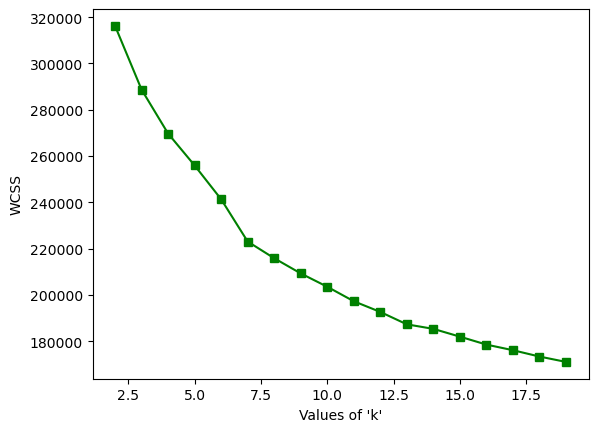

In [23]:
X = scaled_track_feat_df.values
wcss = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(2, 20):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
        kmeans.fit(X)
        wcss[i] = kmeans.inertia_
    
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

From the graph we can see that the optimal number of clusters is 7. Now we can perform K-means clustering using 7 clusters, and view the cluster centroids and sample labels.

In [86]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kmeans = KMeans(n_clusters=7, random_state=1)
    kmeans.fit(X)
print("Cluster centroids")
print(kmeans.cluster_centers_)
print()
print("Sample labels")
print(kmeans.labels_)

Cluster centroids
[[-0.32974261  0.44329116  0.01108191  0.25498783 -0.05999306  0.04956652
  -0.2706282  -0.12027539  2.8842371  -0.03655885  0.03452541]
 [-1.03535883  0.5828092  -0.04500749  0.49305426  0.18528064 -0.31331169
  -0.51861091 -0.26262981 -0.05962351 -0.66544834  0.59617761]
 [ 0.42514059 -0.2629524   0.08602803 -0.11315459 -0.13842278  2.21707273
   0.08517549 -0.32894597 -0.08653082  0.1254357   0.14029335]
 [-0.43218761 -1.60273591 -0.04369712 -1.35721479  0.13124651 -0.34729712
   1.73171377  0.08804142 -0.27363382 -0.54861669 -0.31388898]
 [ 0.45925382  0.13877856 -0.21766241  0.15370716  0.87617693 -0.29088241
  -0.1842663  -0.31341471 -0.23569205  0.54025909 -0.23250553]
 [ 0.45275635  0.12102441  0.26812638  0.19865206 -1.14132199 -0.24413607
  -0.15445644 -0.29738662 -0.23264737  0.39865821 -0.19588923]
 [ 0.05649573  0.46838203 -0.01123705 -0.06956447 -0.01108692 -0.35356024
  -0.46378095  2.98944154 -0.11002971 -0.55353661  0.15585395]]

Sample labels
[4 4 5 

Now, lets utilize PCA to visualize our clusters in 2 dimensions.

In [87]:
pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(X), columns=['Feature 1', 'Feature 2'])

# Reduce the cluster centroids
reduced_centers = pca.transform(kmeans.cluster_centers_)
print(reduced_centers)

print("Variance explained by each component:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

[[ 1.03705431 -0.57235394]
 [ 0.96678373 -1.19655535]
 [-0.24062398  1.1753636 ]
 [-2.73458857 -0.63501118]
 [ 0.22867587  0.52065079]
 [ 0.24704314  0.78494033]
 [ 0.23994061 -1.31030661]]
Variance explained by each component: [0.1956628  0.13811649]
Total variance explained: 0.33377929135518714


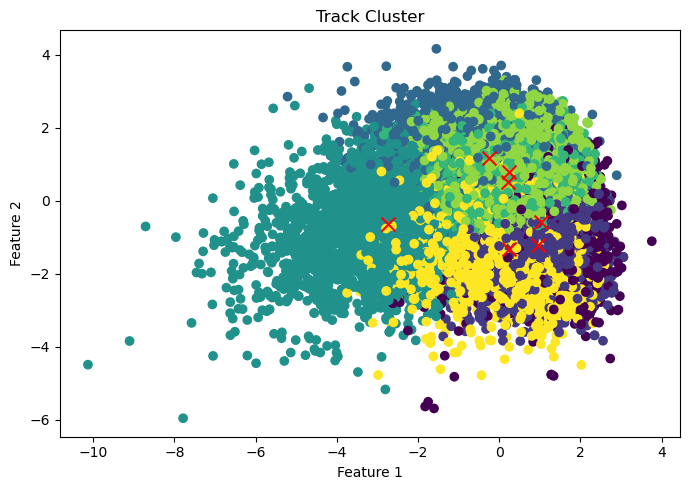

In [88]:
plt.figure(figsize=(7,5))
 
# Scatter plot
plt.scatter(reduced_X['Feature 1'], reduced_X['Feature 2'], c=kmeans.labels_)
plt.scatter(reduced_centers[:,0], reduced_centers[:,1], marker='x', s=100, c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Track Cluster')
plt.tight_layout()

As we can see, PCA does not provide a good visualisation of our clustering, as supported by the low explained variance and highly overlapping clusters in the plot. Let us try using a different visualisation technique, **t-SNE**.

In [52]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)

# Combine data points and cluster centers for joint embedding
combined_data = np.vstack([X, kmeans.cluster_centers_])
tsne_results = tsne.fit_transform(combined_data)

# Separate the results back into points and centers
n_points = X.shape[0]
tsne_points = tsne_results[:n_points]
tsne_centers = tsne_results[n_points:]

# print("Variance explained by each component:", pca.explained_variance_ratio_)
# print("Total variance explained:", sum(pca.explained_variance_ratio_))

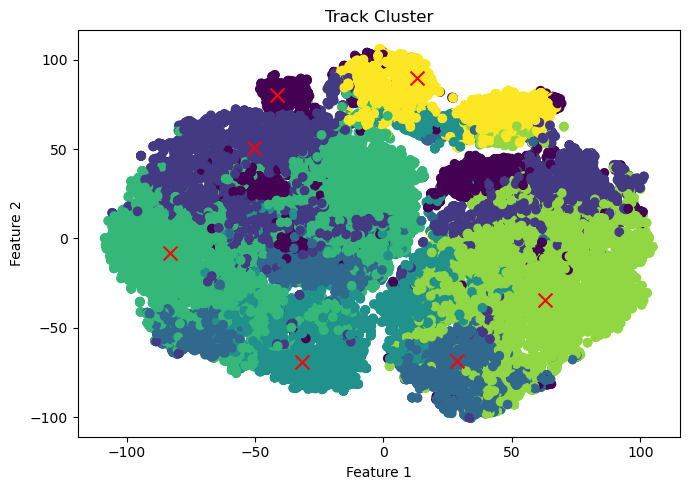

In [58]:
tsne_X = pd.DataFrame(tsne_points, columns=['Feature 1', 'Feature 2'])
plt.figure(figsize=(7,5))
 
# Scatter plot
plt.scatter(tsne_X['Feature 1'], tsne_X['Feature 2'], c=kmeans.labels_)
plt.scatter(tsne_centers[:,0], tsne_centers[:,1], marker='x', s=100, c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Track Cluster')
plt.tight_layout()


While a little better than PCA, it still does not give us a good representation of our clustering. Let us now try another visualisation, **UMAP**.

In [89]:
umap_reducer = umap.UMAP(
    n_components=2,
    random_state=1,
    n_neighbors=50,
    min_dist=0.1
)

umap_embedded = umap_reducer.fit_transform(X)
umap_centers = umap_reducer.transform(kmeans.cluster_centers_)

c:\Users\2004e\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


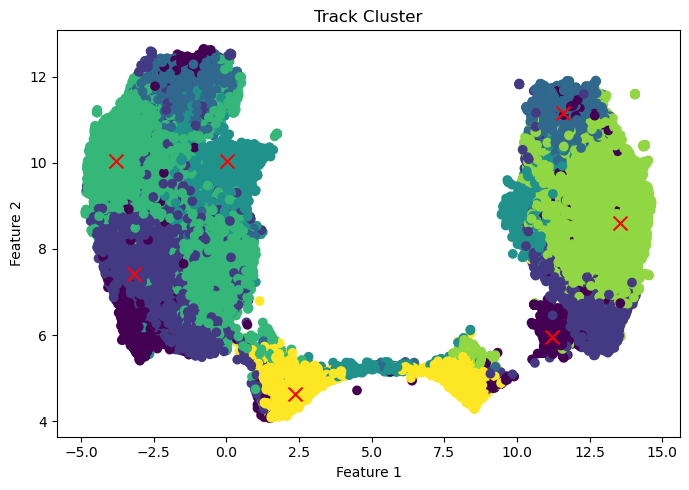

In [90]:
umap_X = pd.DataFrame(umap_embedded, columns=['Feature 1', 'Feature 2'])
plt.figure(figsize=(7,5))
 
# Scatter plot
plt.scatter(umap_X['Feature 1'], umap_X['Feature 2'], c=kmeans.labels_)
plt.scatter(umap_centers[:,0], umap_centers[:,1], marker='x', s=100, c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Track Cluster')
plt.tight_layout()

This visualisation clearly shows distinct clusters, albeit with overlaps and gaps. These overlaps could simply be due to the complexity of our data, which makes it harder to visualise it in 2 dimensions. We can try some non-visual metrics to see if our clustering was effective.

In [91]:
# Calculate all three metrics
silhouette = silhouette_score(X, kmeans.labels_)
ch_score = calinski_harabasz_score(X, kmeans.labels_)
db_score = davies_bouldin_score(X, kmeans.labels_)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

Silhouette Score: 0.119
Calinski-Harabasz Score: 3387.172
Davies-Bouldin Score: 1.830


The Silhouette score of **0.119** (range: -1 to +1) indicates that while there is some structure to the clusters, they show significant overlap. This relatively low score suggests that many data points lie close to cluster boundaries, rather than being tightly grouped within their assigned clusters.

The Calinski-Harabasz score of **3387.172** indicates reasonable cluster separation, though this metric is most meaningful when compared across different clustering solutions. The Davies-Bouldin score of **1.830** further supports the observation of moderate cluster overlap, as lower values indicate better separation.

Thus, we conclude that this might be the best we can do with K-Means clustering, and perhaps our data is not suited for this method.

Now, lets explore the following alternative clustering methods:
- Hierarchical Clustering
- DBSCAN